# Measure Clinker hydrate fringe
This is a script to measure the hydrate fringe around a clinker grain.

## loading required libaries

In [1]:
from functions import *
import pandas as pd

load_example = True
home_dir = os.path.abspath("")

In [2]:
specimen = 'C3S' # or C2S
label = 'C$_{3}$S'
meta_path = home_dir + os.sep + 'last_processed_{}.meta'.format(specimen)

## load pre-processed data
Load the meta file and the result files

In [3]:
if not os.path.isfile(meta_path):
	raise Exception('No meta file found! Process some images first!')
else:
	# load meta file
	df_meta = pd.read_csv(meta_path)
	df_meta = df_meta.loc[:, ~df_meta.columns.str.contains('^Unnamed')]
	#print(df_meta)
	df_meta = df_meta.sort_values(by=['age'])

	# make some basic values available
	unit = df_meta.unit.iloc[0]
	if not df_meta.unit.eq(unit).all(): print('WARNING: There is more than one base unit!')
	tiff_files = [] #df_meta.file_path.to_list()
	min_vals   = [] #df_meta.min_rim.to_list()
	max_val    = df_meta.max_rim.max()
	y_limit    = [0,max_val]

	# load result files
	dataframes = []
	labels     = []
	ages       = []
	scaling    = []
	j = 0

	for i, row in df_meta.iterrows():
		#if not os.path.isfile( row['file_path'] ):
		#	print("'{}' not found.".format( row['file_path']) )
		#else:
		if os.path.isfile( row['file_path'] ):
			file_dir  = os.path.dirname(  row['file_path'] )
			file_name = os.path.basename( row['file_path'] ).split('.', 1)[0]

			dataset_file_name1 = file_dir + os.sep + file_name + "_hyd-rim"
			dataset_file_name2 = file_dir + os.sep + file_name + "_particles"

			error = False
			if os.path.isfile(dataset_file_name1+'.feather'):
				dataframes.append( {
					'hydrate_fringes' : pd.read_feather( dataset_file_name1 + ".feather" ),
					'particles'       : pd.read_feather( dataset_file_name2 + ".feather" )
				} )
			elif os.path.isfile(dataset_file_name1+'.csv'):
				dataframes.append( {
					'hydrate_fringes' : pd.read_csv( dataset_file_name1 + ".csv" ),
					'particles'       : pd.read_csv( dataset_file_name2 + ".csv" )
				} )
			else:
				error = True
				print('Error! Dataset of {} is not net processed or result files are missing!'.format(row['label']))
				dataframes.append( {
								'hydrate_fringes' : [],
								'particles'       : []
							} )

			if not error:
				tiff_files.append( row['file_path'] )
				#min_vals.append( .1)#row['min_rim'] )
				min_vals.append( row['min_rim'] )
				labels.append( row['age'] )#'{} d'.format( row['age'] ) )
				ages.append( row['age'] )
				scaling.append(row['s_x'])
				w = row['w_px']*row['s_x']
				h = row['h_px']*row['s_y']
				print( 'loaded', row['label'], '({:.1f} x {:.1f} = {:.1f} {}² - {:.4f} {}/px'.format(w, h, w*h, row['unit'], row['s_x'], row['unit']))
				print( '  hydrate_fringes', len(dataframes[j]['hydrate_fringes']), end='' )
				print( ', particles', len(dataframes[j]['particles']), ', {:.4f} particles per {}²'.format( len(dataframes[j]['particles'])/(w*h), row['unit'] ), end="\n\n" )
			j += 1

	ages = np.unique(ages)
	if j < 1: raise Exception('No meta file found! Process some images first!')

	# prepare data dict
	data  = {'full':[]}

loaded C$_{3}}$S, 1d hydration (749.9 x 738.9 = 554076.0 µm² - 0.0349 µm/px
  hydrate_fringes 3246248, particles 13301 , 0.0240 particles per µm²

loaded C$_{3}}$S, 7d hydration (1554.0 x 1554.0 = 2414917.6 µm² - 0.0843 µm/px
  hydrate_fringes 3515013, particles 17219 , 0.0071 particles per µm²

loaded C$_{3}}$S, 14d hydration (1554.0 x 1554.0 = 2414917.6 µm² - 0.0843 µm/px
  hydrate_fringes 4096521, particles 27336 , 0.0113 particles per µm²

loaded C$_{3}}$S, 28d hydration (1554.0 x 1554.0 = 2414917.6 µm² - 0.0843 µm/px
  hydrate_fringes 2305692, particles 20776 , 0.0086 particles per µm²



In [4]:
print( df_meta.columns )

Index(['specimen', 'age', 'label', 't_pores', 't_clinker', 'enhance_hist',
       'denoise', 'denoising_algorithm', 'min_grain_dia', 'max_grain_dia',
       'min_circularity', 'max_rim', 'min_rim', 'reduce', 'file_path', 'w_px',
       'h_px', 'unit', 's_x', 's_y', 'segmentation_folder'],
      dtype='object')


## define some functions to plot the graphs

10
a * e^(-0.5 * ((log(x-d)-b)/c)^2)
a = 1.012±0.005,
b = -1.496±0.037,
c = 0.985±0.016,
d = 0.223±0.010


d:\GIT\measure_hydrate_layer\functions.py:443: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = ax[1,0].pcolormesh(Y, X, Z, vmin=0, vmax=1.0, cmap='ocean_r')


33.3 % of measurements: 0.45+0.14-0.17 µm / 0.31 to 0.63 µm
50.0 % of measurements: 0.45+0.17-0.24 µm / 0.28 to 0.70 µm


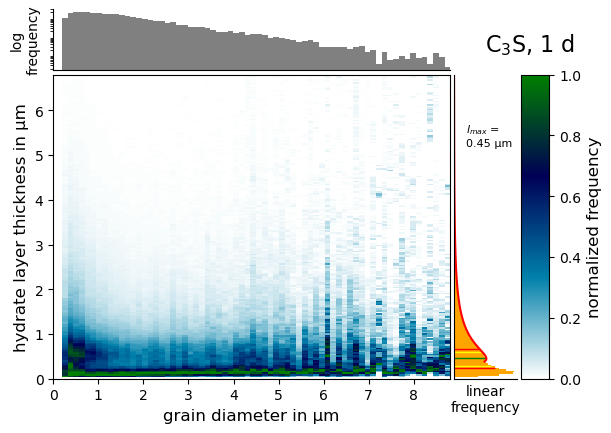

6
a * e^(-0.5 * ((log(x-d)-b)/c)^2)
a = 0.941±0.018,
b = -0.134±0.079,
c = 0.569±0.035,
d = 0.495±0.055
33.3 % of measurements: 1.35+0.25-0.34 µm / 1.10 to 1.69 µm
50.0 % of measurements: 1.35+0.51-0.51 µm / 0.84 to 1.85 µm


d:\GIT\measure_hydrate_layer\functions.py:443: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = ax[1,0].pcolormesh(Y, X, Z, vmin=0, vmax=1.0, cmap='ocean_r')


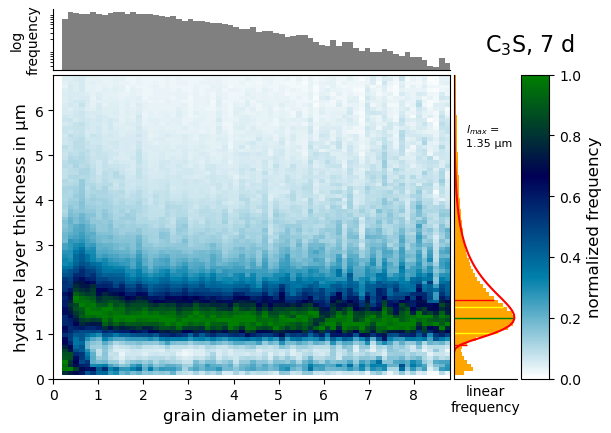

9
a * e^(-0.5 * ((log(x-d)-b)/c)^2)
a = 0.893±0.022,
b = 0.464±0.109,
c = 0.539±0.047,
d = 0.333±0.143
33.3 % of measurements: 1.94+0.42-0.42 µm / 1.52 to 2.36 µm
50.0 % of measurements: 1.94+0.76-0.76 µm / 1.18 to 2.70 µm


d:\GIT\measure_hydrate_layer\functions.py:443: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = ax[1,0].pcolormesh(Y, X, Z, vmin=0, vmax=1.0, cmap='ocean_r')


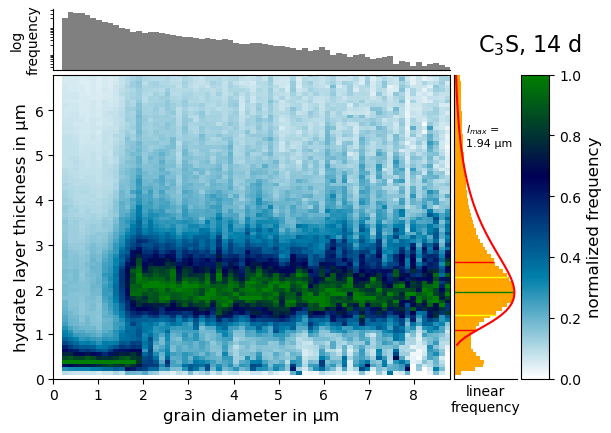

18
a * e^(-0.5 * ((log(x-d)-b)/c)^2)
a = 0.886±0.013,
b = 0.820±0.082,
c = 0.583±0.039,
d = 0.760±0.151
33.3 % of measurements: 3.04+0.59-0.59 µm / 2.44 to 3.63 µm
50.0 % of measurements: 3.04+1.01-0.93 µm / 2.02 to 3.96 µm


d:\GIT\measure_hydrate_layer\functions.py:443: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = ax[1,0].pcolormesh(Y, X, Z, vmin=0, vmax=1.0, cmap='ocean_r')


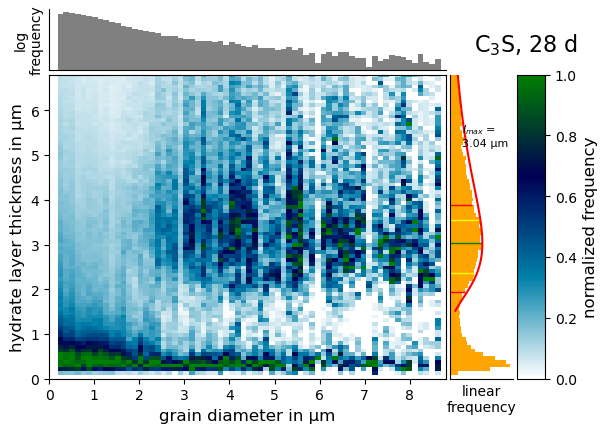

In [5]:
from matplotlib.gridspec import GridSpec
fig, ax = plt.subplots( 2, 3 )
plt.close()
max_values = [[0],[0],[0],[0],[0]]
grenzwerte = []
width_f = 1/8
smooting_f = 1
max_dia = 9
max_dia_rim = 7
min_circularity = 0.3
for j, age in enumerate(ages):
	#if len(dataframes[j]['particles']) > 0:
	df_particles = dataframes[j]['particles'][(dataframes[j]['particles'].circularity > min_circularity) & (dataframes[j]['particles'].diameter <= max_dia)]
	data = plot_2d_result(df_particles, dataframes[j]['hydrate_fringes'], specimen, label, age, scaling[j], unit, min_vals[j], width_f, smooting_f, max_dia, max_dia_rim)
	max_values[0].append(data[0])
	max_values[1].append(data[2])
	max_values[2].append(data[3])
	max_values[3].append(data[5])
	max_values[4].append(data[6])
	grenzwerte = [data[1], data[4]]

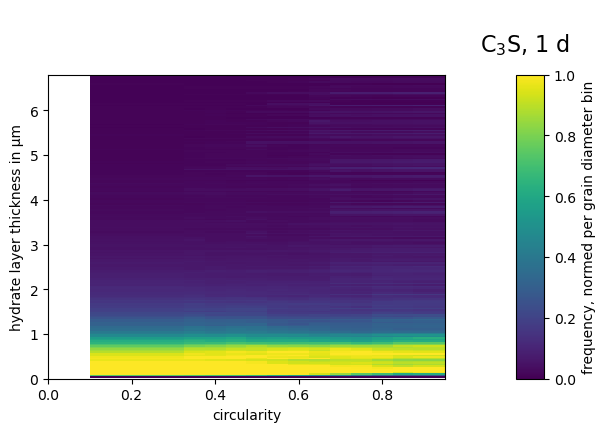

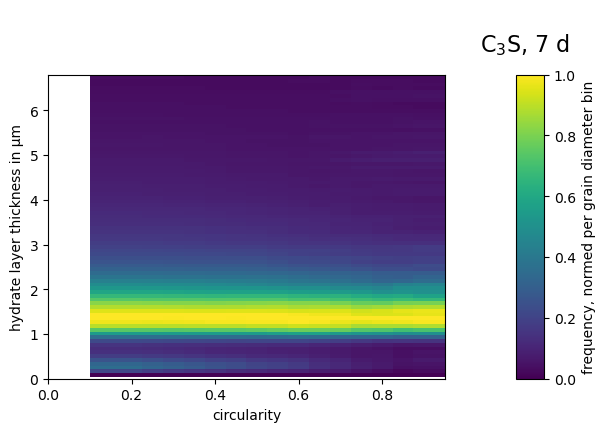

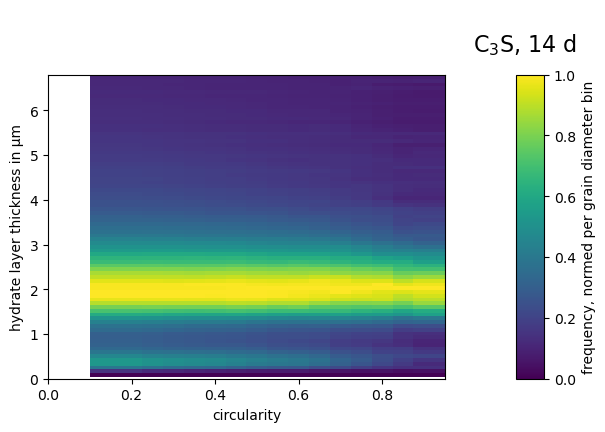

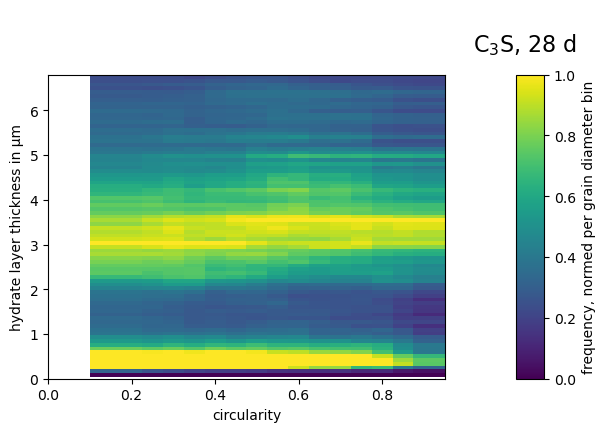

In [6]:
def plot_circularity_dependency(particle_df, hydrate_rim_df, specimen, label, age, scale, unit, min_val, width_f = 1/8, smooting_f = 1, max_dia = 9, max_dia_rim = 7):
	from matplotlib.gridspec import GridSpec
	fig, ax = plt.subplots( 2, 3 )
	plt.close()

	grain_diameters = np.linspace(0,max_dia, num=int(max_dia/width_f))

	f = 1#math.floor(max_dia_rim / (scale*100))
	if f <= 1: f = 1
	max_rim_pos = 0
	bins = [0]
	i=0
	while max_rim_pos < (max_dia_rim*1.1)/scale: # recalculate µm to px
		max_rim_pos += 1
		i += 1
		if i%f==0: bins.append(max_rim_pos)
	bins = np.array(bins)

	bin_centres = ((bins[:-1] + bins[1:]) / 2)
	data3D = np.zeros((len(grain_diameters), len(bin_centres)))

	ommit_steps = 4
	steps = 20
	R = []
	Y = [ommit_steps/steps/2]
	for c in range(ommit_steps, steps+1):
		circ = c/steps
		p_df_filtered = particle_df[(particle_df.circularity > circ)].copy()
		df = pd.merge(hydrate_rim_df, p_df_filtered[['area', 'diameter', 'perimeter', 'circularity', 'measure_percent']], left_on='particle', right_index=True)

		measurements_per_dia = np.zeros((len(grain_diameters)))
		#particles = np.zeros((len(grain_diameters)))
		for i, dia in enumerate( grain_diameters):
			df_filtered = df[(df.diameter < dia+(width_f*smooting_f)) & (df.diameter > dia)] # & (df['measure_percent'] > 0.25)]
			if len(df_filtered) > 0:
				count, division = np.histogram(df_filtered['len_px'], bins=bins)
				measurements_per_dia[i] = len(df_filtered)
				count = count/count.max()
				data3D[i] = count

		Z = np.array(data3D)
		X, _ = np.meshgrid(bin_centres*scale, grain_diameters) #reintroduce scaling

		S = Z.sum(0)
		for idx, x in enumerate(X[0]):
			if x > min_val:
				#x_min_idx = idx
				break
		R.append( S[:-1]/S[idx:].max() )
		Y.append(circ+1/steps/2)

	R = np.array(R)
	#Y = np.array(Y)
	X, Y = np.meshgrid(bin_centres*scale, Y) #reintroduce scaling
	fig = plt.figure()
	gs = GridSpec(nrows=2, ncols=3, width_ratios=[1, 0.16, 0.07], height_ratios=[0.2, 1], wspace=0.025, hspace=0.025)

	ax[0,1] = fig.add_subplot(gs[0,1:2])
	ax[0,1].axis("off")
	ax[0,1].text(1.2, 0.3, "{}, {} d".format(label, age), horizontalalignment='center', fontsize=16)


	ax[1,0] = fig.add_subplot(gs[1,0])
	plot = ax[1,0].pcolormesh(Y, X, R, vmin=0, vmax=1.0)#, cmap='ocean_r')
	ax[1,0].set_ylabel( "hydrate layer thickness in µm" )
	ax[1,0].set_ylim([0,max_dia_rim - .2])
	ax[1,0].set_xlabel( "circularity" )
	ax[1,0].set_xlim([0,0.95])
	ax[0,0].grid(visible=False, which='both', axis='x')


	ax[1,2] = fig.add_subplot(gs[1,2])
	#ax[1,2].axis("off")
	cbar = fig.colorbar(plot,cax=ax[1,2])
	cbar.set_label('frequency, normed per grain diameter bin')


	#plt.savefig( "{} {} 2d rim histogram.pdf".format(specimen, age) )
	plt.show()

for j, age in enumerate(ages):
	if len(dataframes[j]['particles']) > 0:
		plot_circularity_dependency(dataframes[j]['particles'], dataframes[j]['hydrate_fringes'], specimen, label, age, scaling[j], unit, min_vals[j], width_f, smooting_f, max_dia, max_dia_rim)

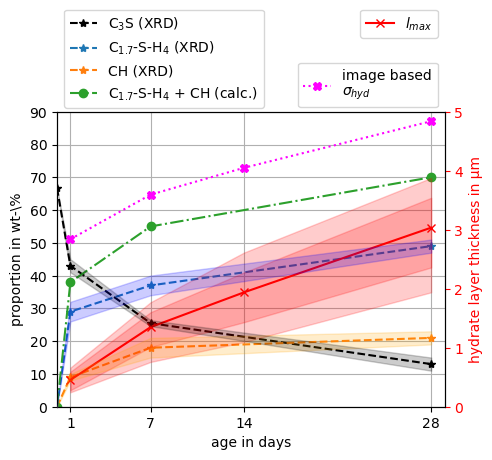

In [11]:
df2 = pd.read_csv(home_dir + os.sep + 'C3S' + os.sep + '20230621_XRD Daten C3S.csv', delimiter=';')
df2['hydrate [wt.%]'] = df2['C1.7-S-H4 [wt.%]']+df2['CH [wt.%]']
#area-%
#ax.plot(ages[:4], [61.4,73.5,80.3,91,0], label='hydrate phase (image)', ls='', marker="X", color="fuchsia")#, color="black")
#ax.plot(ages[:4], [51.1,64.7,46.6,82.5], label='hydrates (image)', ls='', marker="X", color="fuchsia")#, color="black")

fig, ax = plt.subplots( 1, 1, figsize=( 5, 5 ) )

ax.grid(visible=True, which='both')
ax.set_ylim([0,90])
ax.set_ylabel( "proportion in wt-\%" )
ax.set_xticks( ages, labels )
ax.set_xlim([0,29])
ax.set_xlabel( "age in days" )

ax2 = ax.twinx()
ax2.grid(visible=False, which='both', axis='y')
ax2.set_ylabel('hydrate layer thickness in µm', color='r')
ax2.tick_params('y', colors='r')
ax2.set_ylim([0,5])

ax3 = ax.twinx()
ax3.axis("off")
ax3.grid(visible=False, which='both', axis='y')
ax3.set_ylim([0,90])

ax2.fill_between(ages, max_values[2][1:5], max_values[1][1:5], alpha=0.2, color='r') # grenzwerte[0]
ax2.fill_between(ages, max_values[3][1:5], max_values[4][1:5], alpha=0.2, color='r') # grenzwerte[1]
ax2.plot(ages, max_values[0][1:5], label="$l_{max}$", color='r', marker="x")#, color="black"

ax.plot(df2['age [d]'], df2['C3S [wt.%]'], label='C$_{3}$S (XRD)', color="black", ls='--', marker="*")
ax.plot(df2['age [d]'], df2['C1.7-S-H4 [wt.%]'], label='C$_{1.7}$-S-H$_{4}$ (XRD)', ls='--', marker="*")
ax.plot(df2['age [d]'], df2['CH [wt.%]'], label='CH (XRD)', ls='--', marker="*")
ax.plot(df2['age [d]'], df2['hydrate [wt.%]'], label='C$_{1.7}$-S-H$_{4}$ + CH (calc.)', ls='-.', marker="o")#, color="black")
ax3.fill_between(df2['age [d]'], df2['CH [wt.%]']-df2['CH SD [wt.%]'], df2['CH [wt.%]']+df2['CH SD [wt.%]'], alpha=0.2, color='orange') # grenzwerte[0]
ax3.fill_between(df2['age [d]'], df2['C3S [wt.%]']-df2['C3S SD [wt.%]'], df2['C3S [wt.%]']+df2['C3S SD [wt.%]'], alpha=0.2, color='black') # grenzwerte[0]
ax3.fill_between(df2['age [d]'], df2['C1.7-S-H4 [wt.%]']-df2['C1.7-S-H4 SD [wt.%]'], df2['C1.7-S-H4 [wt.%]']+df2['C1.7-S-H4 SD [wt.%]'], alpha=0.2, color='blue') # grenzwerte[0]
#ax.errorbar(df2['age [d]'], df2['H2O [wt.%]'], yerr=df2['H2O [wt.%]'], label='H2O')#, color="black")

ax3.plot([1,7,14,28], [51.1,64.7,72.9,87.1], label='image based\n'r"$\sigma_{hyd}$", ls=':', marker="X", color="fuchsia")#, color="black")

ax.legend( loc='upper left', bbox_to_anchor=(0, 1.37), shadow=False, ncol=1)
ax3.legend(loc='upper right', bbox_to_anchor=(1, 1.19), shadow=False, ncol=1)
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1.37), shadow=False, ncol=1)


fig.subplots_adjust(top=0.7)

plt.savefig(home_dir + os.sep + 'compare to hydration.pdf')#.format(title)
plt.show()

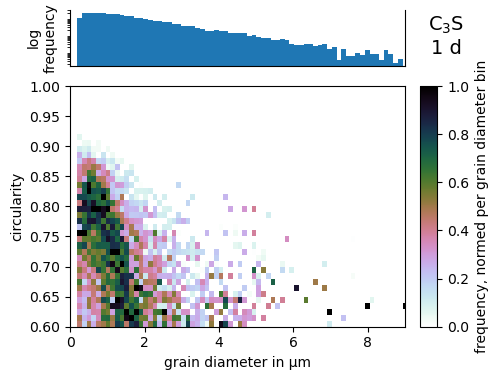

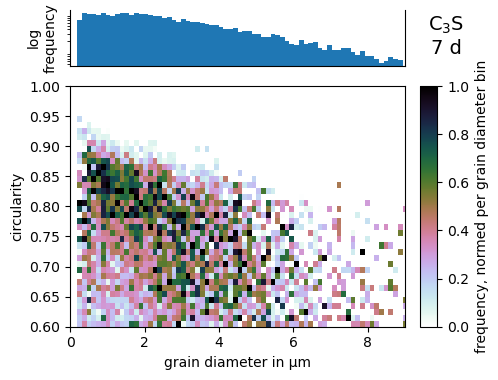

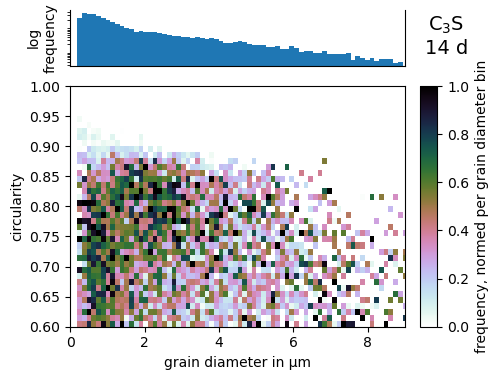

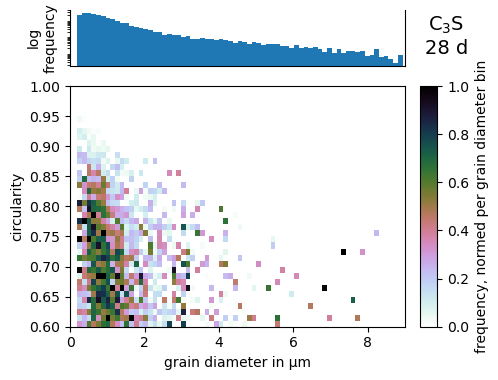

In [8]:
import matplotlib.ticker
width_f = 1/8
smooting_f = 1
max_dia = 9
max_dia_rim = 100
grain_diameters = np.linspace(0,max_dia, num=int(max_dia/width_f))
for j in range(len(ages)):
	#bins = np.linspace(0,max_dia_rim, num=50)
	f = 1#math.floor(max_dia_rim / (scaling[j]*100))
	if f <= 1: f = 1
	max_rim_pos = 0
	bins = [0] #scaling[j]*0.1]
	i=0
	while max_rim_pos < (max_dia_rim*1.1)/scaling[j]: # recalculate µm to px
		max_rim_pos += 1#scaling[j]
		i += 1
		if i%f==0: bins.append(max_rim_pos*0.01)
	bins = np.array(bins)

	bin_centres = ((bins[:-1] + bins[1:]) / 2)
	data3D = np.zeros((len(grain_diameters), len(bin_centres)))

	df = dataframes[j]['hydrate_fringes']
	df = pd.merge(df, dataframes[j]['particles'][['area', 'diameter', 'perimeter', 'circularity', 'measure_percent']], left_on='particle', right_index=True)

	measurements_per_dia = np.zeros((len(grain_diameters)))
	particles = np.zeros((len(grain_diameters)))
	for i, dia in enumerate( grain_diameters):
		df_filtered = df[(df.diameter < dia+(width_f*smooting_f)) & (df.diameter > dia)]# & (df['measure_percent'] > 0.25)]
		if len(df_filtered) > 0:
			count, division = np.histogram(df_filtered['circularity'], bins=bins)
			measurements_per_dia[i] = len(df_filtered)
			count = count/count.max()
			data3D[i] = count

	Z = np.array(data3D)
	X, Y = np.meshgrid(bin_centres, grain_diameters) #reintroduce scaling

	fig, ax = plt.subplots( 2,2,figsize=( 5, 3.9 ),  gridspec_kw={'height_ratios':[3,13],"width_ratios":[95,5]})
	#fig.suptitle( "hydrate rim histograms ({} days).\n\n".format( ages[j] ), fontsize=16 )

	ax[0,0].set_yscale('log')
	ax[0,0].grid(visible=False, which='both', axis='y')
	#ax[0,0].plot(grain_diameters, measurements_per_dia)
	#ax[0,0].stairs(measurements_per_dia[1:], grain_diameters)
	ax[0,0].hist(grain_diameters[:-1]-grain_diameters[1]/2, grain_diameters-grain_diameters[1]/2, weights=measurements_per_dia[:-1], linewidth=0)
	ax[0,0].set_xlim([0,max_dia])
	ax[0,0].set_ylabel( "log\nfrequency" )
	#ax[0,0].set_ylim([0,measurements_per_dia.max()*1.05])
	#ax[0,0].set_yticks([0,measurements_per_dia.max()])
	ax[0,0].set_yticks([])
	ax[0,0].set_xticks([])
	ax[0,0].tick_params(axis="x", labelbottom=0)
	ax[0,0].spines[['top']].set_visible(False)

	ax[0,1].axis("off")
	ax[0,1].text(1.5, 0.2, "{}\n{} d".format(label, ages[j]), horizontalalignment='center', fontsize=14)

	plot = ax[1,0].pcolormesh(Y,X, Z, vmin=0, vmax=1.0, cmap='cubehelix_r')
	ax[1,0].set_ylabel( "circularity" )
	ax[1,0].set_ylim([0.6,max_dia_rim*.01])
	ax[1,0].set_xlabel( "grain diameter in µm" )
	ax[1,0].set_xlim([0,max_dia])

	cbar = fig.colorbar(plot,cax=ax[1,1])
	cbar.set_label('frequency, normed per grain diameter bin')


	plt.tight_layout()
	plt.show()


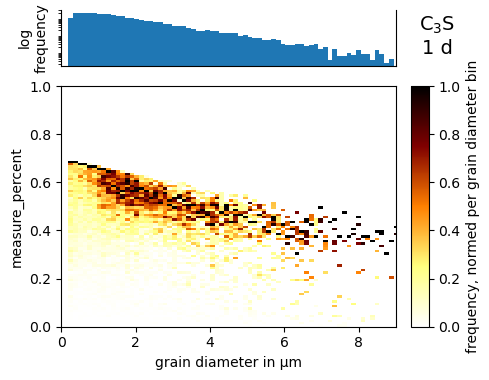

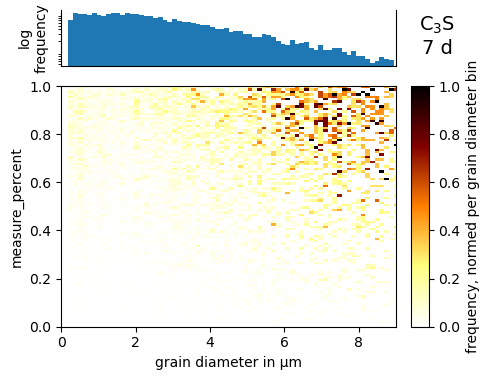

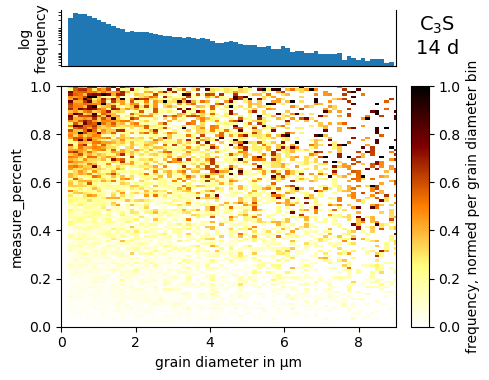

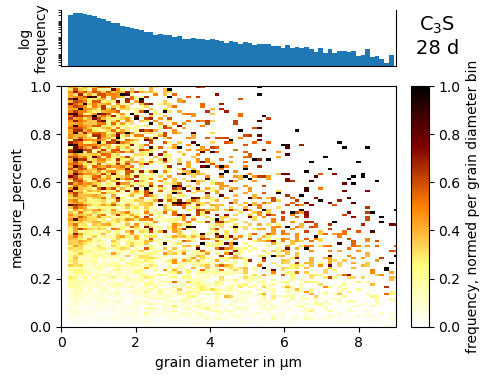

In [9]:
import matplotlib.ticker
width_f = 1/8
smooting_f = 1
max_dia = 9
max_dia_rim = 100
grain_diameters = np.linspace(0,max_dia, num=int(max_dia/width_f))
for j in range(len(ages)):
	#bins = np.linspace(0,max_dia_rim, num=50)
	f = 1#math.floor(max_dia_rim / (scaling[j]*100))
	if f <= 1: f = 1
	max_rim_pos = 0
	bins = [0] #scaling[j]*0.1]
	i=0
	while max_rim_pos < (max_dia_rim*1.1)/scaling[j]: # recalculate µm to px
		max_rim_pos += 1#scaling[j]
		i += 1
		if i%f==0: bins.append(max_rim_pos*0.01)
	bins = np.array(bins)

	bin_centres = ((bins[:-1] + bins[1:]) / 2)
	data3D = np.zeros((len(grain_diameters), len(bin_centres)))

	df = dataframes[j]['hydrate_fringes']
	df = pd.merge(df, dataframes[j]['particles'][['area', 'diameter', 'perimeter', 'circularity', 'measure_percent']], left_on='particle', right_index=True)

	measurements_per_dia = np.zeros((len(grain_diameters)))
	particles = np.zeros((len(grain_diameters)))
	for i, dia in enumerate( grain_diameters):
		df_filtered = df[(df.diameter < dia+(width_f*smooting_f)) & (df.diameter > dia)]# & (df['measure_percent'] > 0.25)]
		if len(df_filtered) > 0:
			count, division = np.histogram(df_filtered['measure_percent'], bins=bins)
			measurements_per_dia[i] = len(df_filtered)
			count = count/count.max()
			data3D[i] = count

	Z = np.array(data3D)
	X, Y = np.meshgrid(bin_centres, grain_diameters) #reintroduce scaling

	fig, ax = plt.subplots( 2,2,figsize=( 5, 3.9 ),  gridspec_kw={'height_ratios':[3,13],"width_ratios":[95,5]})
	#fig.suptitle( "hydrate rim histograms ({} days).\n\n".format( ages[j] ), fontsize=16 )

	ax[0,0].set_yscale('log')
	ax[0,0].grid(visible=False, which='both', axis='y')
	#ax[0,0].plot(grain_diameters, measurements_per_dia)
	#ax[0,0].stairs(measurements_per_dia[1:], grain_diameters)
	ax[0,0].hist(grain_diameters[:-1]-grain_diameters[1]/2, grain_diameters-grain_diameters[1]/2, weights=measurements_per_dia[:-1], linewidth=0)
	ax[0,0].set_xlim([0,max_dia])
	ax[0,0].set_ylabel( "log\nfrequency" )
	#ax[0,0].set_ylim([0,measurements_per_dia.max()*1.05])
	#ax[0,0].set_yticks([0,measurements_per_dia.max()])
	ax[0,0].set_yticks([])
	ax[0,0].set_xticks([])
	ax[0,0].tick_params(axis="x", labelbottom=0)
	ax[0,0].spines[['top']].set_visible(False)

	ax[0,1].axis("off")
	ax[0,1].text(1.5, 0.2, "{}\n{} d".format(label, ages[j]), horizontalalignment='center', fontsize=14)

	plot = ax[1,0].pcolormesh(Y,X, Z, vmin=0, vmax=1.0, cmap='afmhot_r')
	ax[1,0].set_ylabel( "measure_percent" )
	ax[1,0].set_ylim([0,max_dia_rim*.01])
	ax[1,0].set_xlabel( "grain diameter in µm" )
	ax[1,0].set_xlim([0,max_dia])

	cbar = fig.colorbar(plot,cax=ax[1,1])
	cbar.set_label('frequency, normed per grain diameter bin')


	plt.tight_layout()
	plt.show()


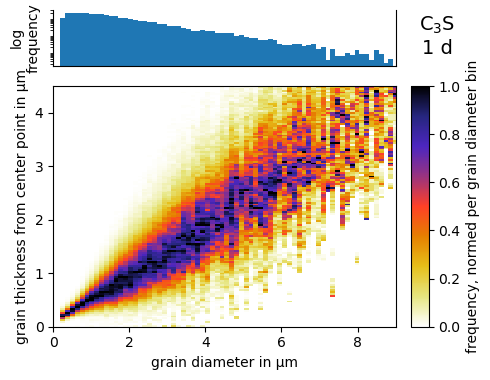

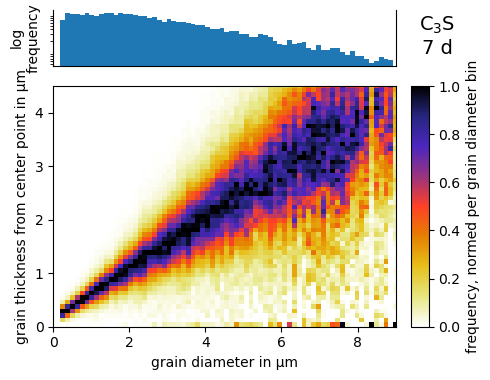

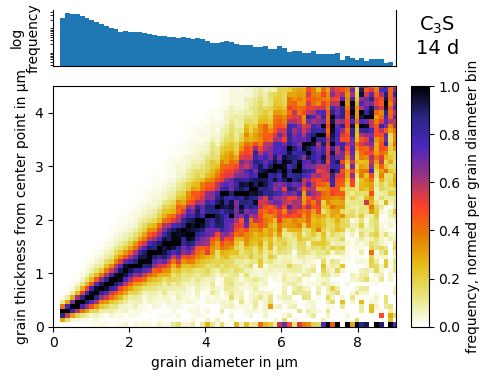

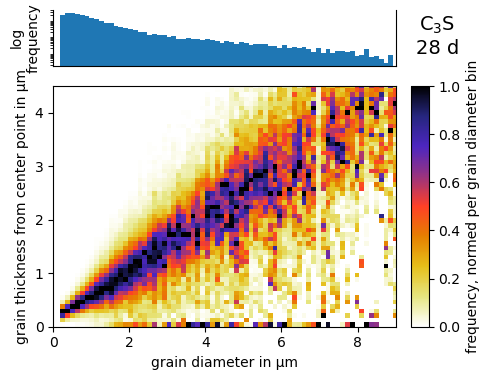

In [10]:
import matplotlib.ticker
width_f = 1/8
smooting_f = 1
max_dia = 9
max_dia_rim = 9/2
grain_diameters = np.linspace(0,max_dia, num=int(max_dia/width_f))
for j in range(len(ages)):
	#bins = np.linspace(0,max_dia_rim, num=50)
	f = 1#math.floor(max_dia_rim / (scaling[j]*100))
	if f <= 1: f = 1
	max_rim_pos = 0
	bins = [0] #scaling[j]*0.1]
	i=0
	while max_rim_pos < (max_dia_rim*1.1)/scaling[j]: # recalculate µm to px
		max_rim_pos += 1#scaling[j]
		i += 1
		if i%f==0: bins.append(max_rim_pos)
	bins = np.array(bins)

	bin_centres = ((bins[:-1] + bins[1:]) / 2)
	data3D = np.zeros((len(grain_diameters), len(bin_centres)))

	df = dataframes[j]['hydrate_fringes']
	df = pd.merge(df, dataframes[j]['particles'][['area', 'diameter', 'perimeter', 'circularity', 'measure_percent']], left_on='particle', right_index=True)

	measurements_per_dia = np.zeros((len(grain_diameters)))
	particles = np.zeros((len(grain_diameters)))
	for i, dia in enumerate( grain_diameters):
		df_filtered = df[(df.diameter < dia+(width_f*smooting_f)) & (df.diameter > dia)]# & (df['measure_percent'] > 0.25)]
		if len(df_filtered) > 0:
			count, division = np.histogram(df_filtered['h_start'], bins=bins)
			measurements_per_dia[i] = len(df_filtered)
			count = count/count.max()
			data3D[i] = count

	Z = np.array(data3D)
	X, Y = np.meshgrid(bin_centres*scaling[j], grain_diameters) #reintroduce scaling

	fig, ax = plt.subplots( 2,2,figsize=( 5, 3.9 ),  gridspec_kw={'height_ratios':[3,13],"width_ratios":[95,5]})
	#fig.suptitle( "hydrate rim histograms ({} days).\n\n".format( ages[j] ), fontsize=16 )

	ax[0,0].set_yscale('log')
	ax[0,0].grid(visible=False, which='both', axis='y')
	ax[0,0].hist(grain_diameters[:-1]-grain_diameters[1]/2, grain_diameters-grain_diameters[1]/2, weights=measurements_per_dia[:-1], linewidth=0)
	ax[0,0].set_xlim([0,max_dia])
	ax[0,0].set_ylabel( "log\nfrequency" )
	ax[0,0].set_yticks([])
	ax[0,0].set_xticks([])
	ax[0,0].tick_params(axis="x", labelbottom=0)
	ax[0,0].spines[['top']].set_visible(False)

	ax[0,1].axis("off")
	ax[0,1].text(1.5, 0.2, "{}\n{} d".format(label, ages[j]), horizontalalignment='center', fontsize=14)

	plot = ax[1,0].pcolormesh(Y,X, Z, vmin=0, vmax=1.0, cmap='CMRmap_r')
	ax[1,0].set_ylabel( "grain thickness from center point in µm" )
	ax[1,0].set_ylim([0,max_dia_rim])
	ax[1,0].set_xlabel( "grain diameter in µm" )
	ax[1,0].set_xlim([0,max_dia])

	cbar = fig.colorbar(plot,cax=ax[1,1])
	cbar.set_label('frequency, normed per grain diameter bin')


	plt.tight_layout()
	plt.show()
